In [1]:
# Import necessary packages.
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import os
from matplotlib.image import imread
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
import cv2
from PIL import Image,ImageDraw, ImageFont
from IPython.display import clear_output

In [ ]:
# Setting plotting parameters
fs = 24
plt.rcParams["font.family"] = "Times New Roman"# "Helvetica"# 
plt.rcParams['mathtext.fontset'] = 'stix' # "stixsans"#
plt.rc('xtick',labelsize= 24)
plt.rc('ytick',labelsize= 24) 
# plt.rcParams["figure.dpi"] = 120

In [3]:
#Loading saved image arrays
data = np.load(r'E:\IC3X_IR\TSP_IC3X_IR.npz')
data.files

['bg_mean', 'Temperature', 'T_cropped']

In [7]:
bg_av = data['bg_mean'] 
temperature = data['Temperature']
T_cropped = data['T_cropped']
Temperature= np.transpose(temperature, (1, 2, 0))
Temperature.shape

(256, 320, 618)

In [8]:
# Constants 
C = 688**2 # J/m2Ks^(1/2) # using estimates form Cary and schramm
Kc = 2*np.sqrt(C/np.pi)
#https://www.researchgate.net/profile/Jan-Martinez-Schramm/publication/275524396_Development_of_Temperature_Sensitive_Paints_in_the_High_Enthalpy_Shock_Tunnel_Gottingen_HEG/links/553f139f0cf20184050fa63d/Development-of-Temperature-Sensitive-Paints-in-the-High-Enthalpy-Shock-Tunnel-Goettingen-HEG.pdf

# # Carbomer Properties for heat transfer estimation
# rho_carbomer = 200 # kg/m3

In [9]:
#initialize a 3d zero array of shape (227, 992, 1) #this is the same shape as that of a single image
flux = np.zeros((Temperature.shape[0],Temperature.shape[1],1))

#initialize time
#Temperature.shape[0]-Row, [1]-Column, [2]-No Of images.
start_time = 50 #specify time in milliseconds
end_time   = 550
#Create a time series from 0 to no.of images with intervals of 1/fps_value. This time series will be in seconds. 
time = np.arange(start_time/1000,end_time/1000,1/1236) 

#specify value for tn last value in time
tn = time[-1]

#initialize a 3d array of shape (227, 992, 1) #this is the same shape as that of a single image 
#this will hold the cumulative sum of flux over time, 
#Hence, first initialize it to zero, running the loop with each time step it will get updated
flux_sum = np.zeros((Temperature.shape[0],Temperature.shape[1],1))

#run for loop over entire time
for t in range(1,len(time)):
    
    #time for ith step
    t_i = time[t]
    
    #time for (i-1)th step
    t_i_1 = time[t-1]
    
    #Temperature for ith time step
    T_i = Temperature[:,:,t]
    
    #Temperature for (i-1)th time step
    T_i_1 = Temperature[:,:,t-1]
    
    # bottom sqrt(tn - ti) + sqrt(tn - ti-1)
    bottom = np.sqrt(tn - t_i) + np.sqrt(tn - t_i_1)
    
    # T(ti)  - T(ti-1)
    top = T_i - T_i_1
    
    #flux at ith time
    flux_i = top/bottom
    
    #cumulative sum of flux until ith time
    flux_sum[:,:,0]+= flux_i
    
    #multiply the final flux sum by Kc and append to flux 3d array
    flux = np.concatenate((flux,flux_sum*Kc),axis = 2)
    
    # Setting counter
    clear_output(wait = True)                          # Counter for cycle for, increases 1 on each loop
    print('Loading image: ' + str(t), end='\r')        # Printing string 

In [10]:
flux.shape

(256, 320, 618)

In [11]:
np.savez_compressed(r'E:\IC3X_IR\heat_flux.npz', heat_flux = flux)

In [12]:
#cropping co-ordinates
#Flipping for visualization only. This is not stored
x1=130
x2=220
y2=165
y1=125

f = flux[y1:y2, x1:x2,:618]

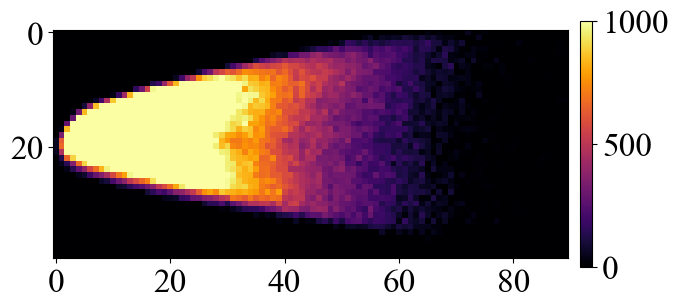

In [20]:
plt.figure(figsize=[8,8])
plt.imshow(f[:,:,10], cmap = 'inferno', vmin=0, vmax=1000)#cmap = 'turbo', vmin = 0.2 , vmax = 1.1
plt.colorbar(shrink=0.4, pad = 0.02)

In [21]:
f_mean = f.mean(axis=2)
f_std = f.std(axis=2)

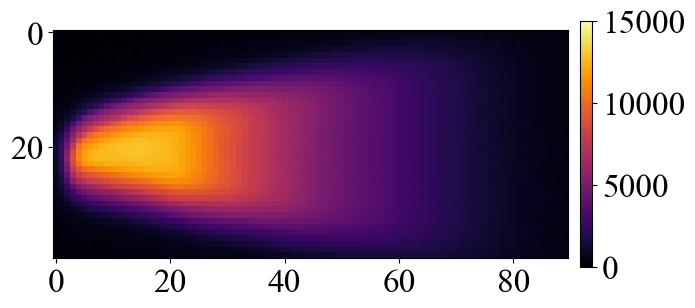

In [27]:
plt.figure(figsize=[8,8])
plt.imshow(f_mean, cmap = 'inferno', vmin=0, vmax=15000)#cmap = 'turbo', vmin = 0.2 , vmax = 1.1
plt.colorbar(shrink=0.4, pad = 0.02)

In [28]:
Y,X = Temperature[0,125:165,130:220].shape #Temperature[:,:,0].shape
#y_1 = 128-2

#origin_x, origin_y = 840,y_1+9
origin_x, origin_y = 90,20
#origin_x, origin_y = 978,105

#scale = 10*25.4/838 # mm/pixel
#scale= 9.96*25.4/973.96
scale= 1.38*25.4/165

x_coords = scale*(origin_x - np.arange(0,X,1))
y_coords = scale*(origin_y - np.arange(0,Y,1))
dia = 25.4 # mm

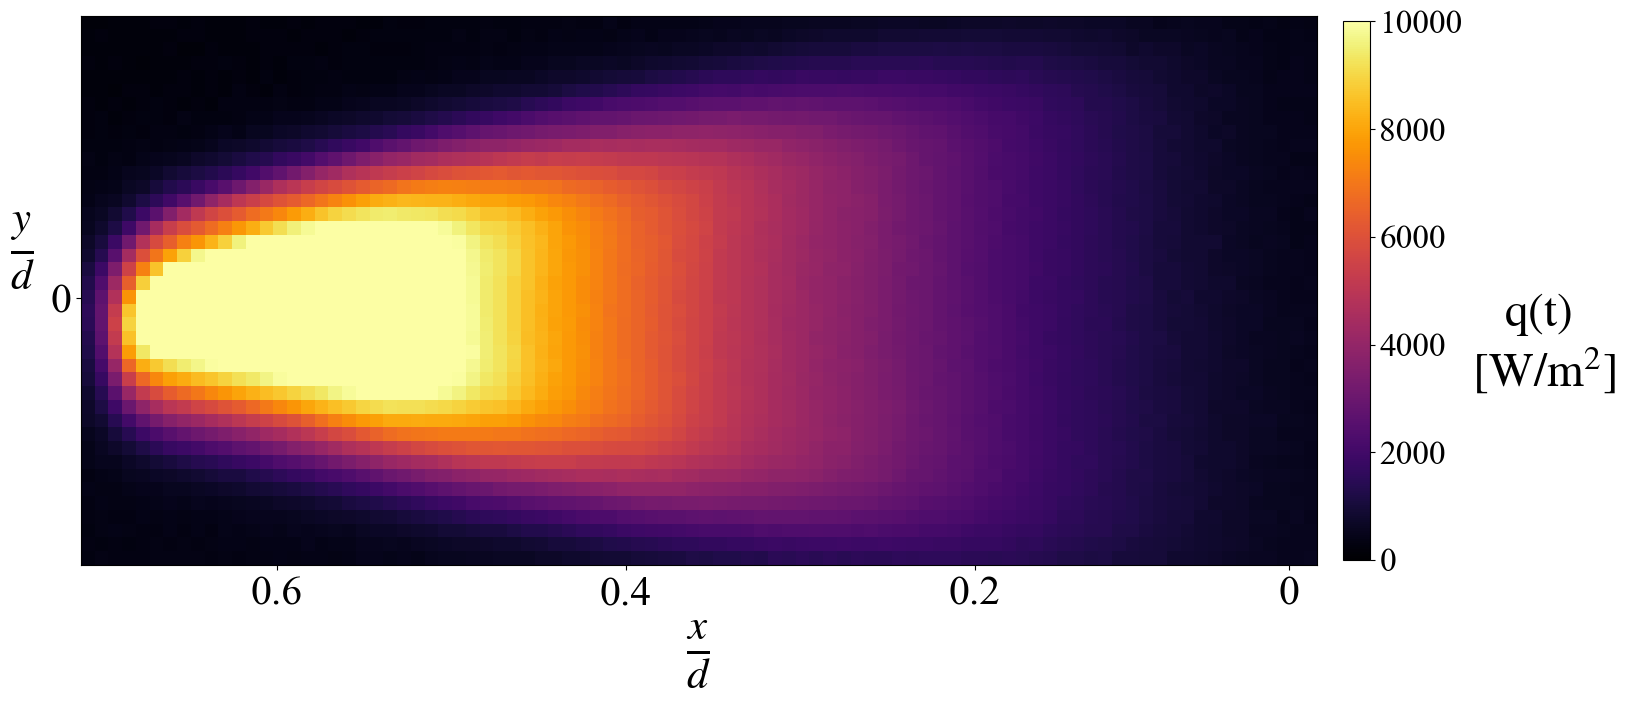

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(15,12)
fig.tight_layout(pad=5.0)


# T_m=delT_mean #np.fliplr(T_mean/426) 
ic3x = flux.mean(axis=2)[125:165,130:220] #ma.masked_where(I_ref<=thresh,T_m)

#plt.imshow(ic3x, cmap = 'turbo', vmin = -0.015,vmax = 0.0)#5AoA
plt.imshow(ic3x, cmap = 'inferno', vmin = 0, vmax = 10000)
cba = plt.colorbar(shrink=0.6, pad = 0.02, fraction = 0.047*(Y/X))
cba.set_label("$\mathrm{q(t)}$ \n $\mathrm{[W/m^{2}]}$", rotation=0, fontsize = fs+10, labelpad = 55)
# cba.set_ticks([5,15,25])
xt = -np.array([0.1,1,2,3])*dia +origin_x
yt = -np.array([0])*dia + origin_y
plt.xticks(xt, fontsize=fs+6)
plt.yticks(yt, fontsize=fs+6)


ticks_y = mticker.FuncFormatter(lambda y, pos: '{0:g}'.format(np.round(scale*(origin_y-y)/dia),1))
ax.yaxis.set_major_formatter(ticks_y)

ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(scale*(origin_x-x)/dia,1),1))
ax.xaxis.set_major_formatter(ticks_x)

plt.xlabel(r'$\frac{x}{d}$', fontsize = fs+20)
plt.ylabel(r'$\frac{y}{d}$',rotation = 0, fontsize = fs+20, labelpad = 20)
plt.show()